# Task 9:  Load the MNIST dataset (introduced in chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).

In [58]:
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import LocallyLinearEmbedding, MDS, TSNE
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [4]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [7]:
# Exercise: Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set.Exercise: Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set.

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

In [8]:
t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 73.11s


In [11]:
y_pred = rnd_clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
score # 0.9705

0.9705

In [12]:
# Exercise: Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.

# apply PCA
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

# apply same transformation to test set
X_test_reduced = pca.transform(X_test)

# train model again on reduced data
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

# evaluate model again on reduced test set
y_pred = rnd_clf2.predict(X_test_reduced)
score = accuracy_score(y_test, y_pred)
score # 0.9488
# Oh no! Training is actually more than twice slower now! How can that be? Well, as we saw in this chapter, dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm


Training took 236.58s


0.9488

In [13]:
# Exercise: Next evaluate the classifier on the test set: how does it compare to the previous classifier?
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
score = accuracy_score(y_test, y_pred)
score # 0.9488

0.9488

In [16]:
# It is common for performance to drop slightly when reducing dimensionality, because we do lose some useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training and reduced performance. :(

# Let's see if it helps when using softmax regression:It is common for performance to drop slightly when reducing dimensionality, because we do lose some useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training and reduced performance. :(
#
# Let's see if it helps when using softmax regression:


log_clf = LogisticRegression(solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 21.54s


C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
y_pred = log_clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
score # 0.9255

0.9255

In [21]:
# Okay, so softmax regression takes much longer to train on this dataset than the random forest classifier, plus it performs worse on the test set. But that's not what we are interested in right now, we want to see how much PCA can help softmax regression. Let's train the softmax regression model using the reduced dataset:

log_clf2 = LogisticRegression(solver="lbfgs", random_state=42, max_iter=95)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()
 # Nice! Reducing dimensionality led to over 2× speedup. :) Let's check the model's accuracy:
print("Training took {:.2f}s".format(t1 - t0)) # 6.24s

y_pred = log_clf2.predict(X_test_reduced)
score = accuracy_score(y_test, y_pred)
score # 0.9201

# A very slight drop in performance, which might be a reasonable price to pay for a 2× speedup, depending on the application.

# So there you have it: PCA can give you a formidable speedup... but not always!

Training took 6.67s


C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 95 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=95).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.92

# Task 10:  Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class.

In [34]:
# Dimensionality reduction on the full 60,000 images takes a very long time, so let's only do this on a random subset of 10,000 images:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

y = y.astype(int)

In [25]:
# Now let's use t-SNE to reduce dimensionality down to 2D so we can plot the dataset:

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

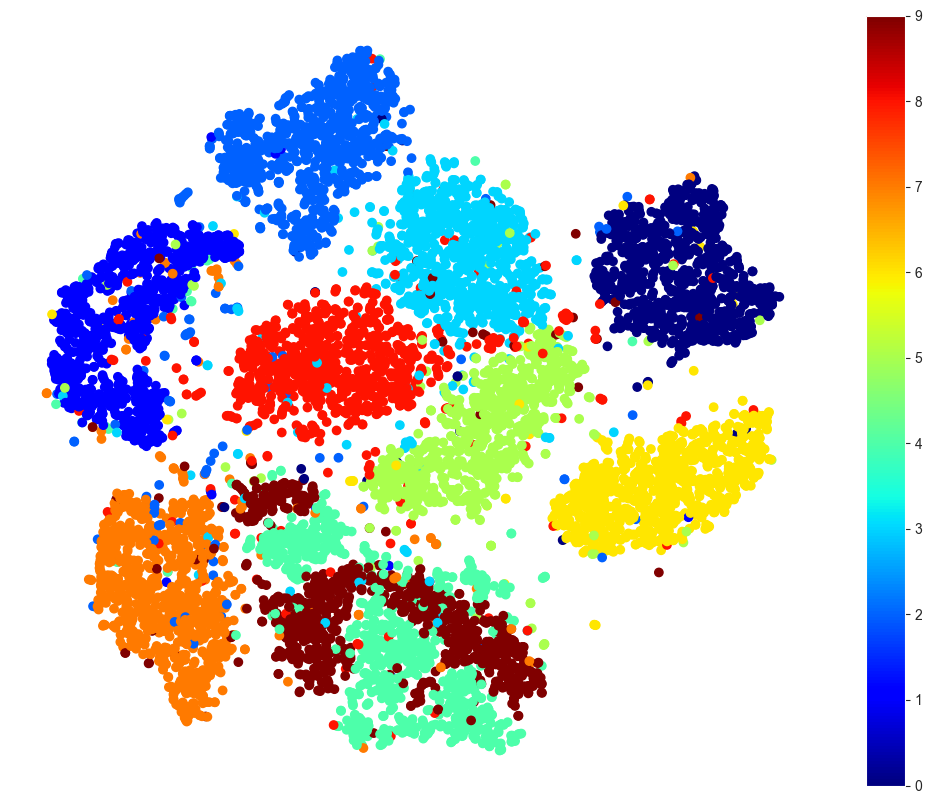

In [29]:
# Now let's use Matplotlib's scatter() function to plot a scatterplot, using a different color for each digit:

plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0],
            X_reduced[:, 1],
            c=y.astype(int),  # # Convert to int
            cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

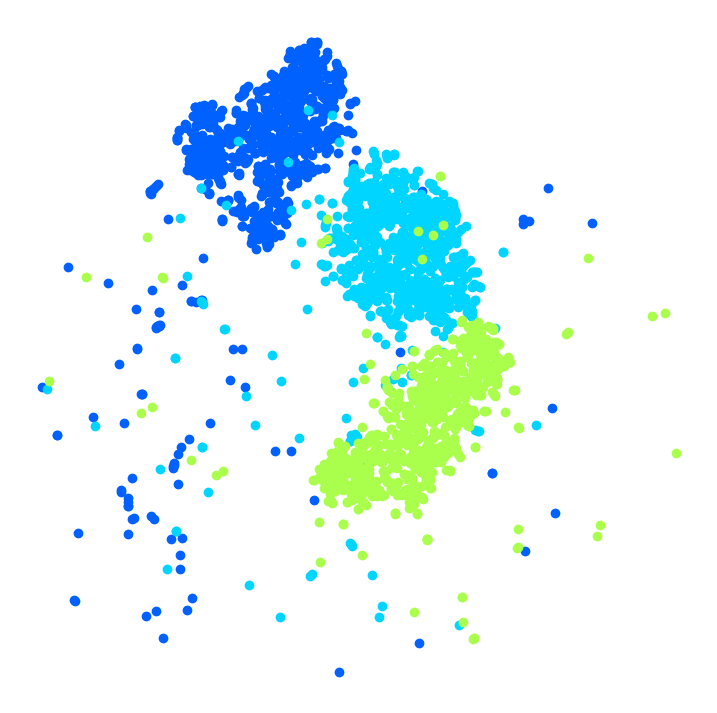

In [35]:
# Isn't this just beautiful? :) This plot tells us which numbers are easily distinguishable from the others (e.g., 0s, 6s, and most 8s are rather well separated clusters), and it also tells us which numbers are often hard to distinguish (e.g., 4s and 9s, 5s and 3s, and so on).

# Let's focus on digits 2, 3 and 5, which seem to overlap a lot.

plt.figure(figsize=(9,9))
cmap = mpl.colormaps.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0],
                X_reduced[y == digit, 1],
                c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

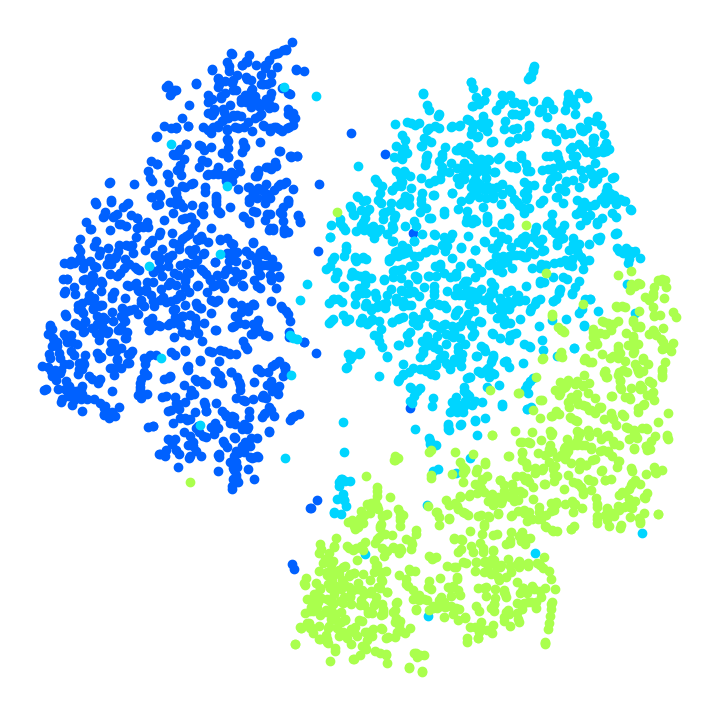

In [36]:
# Let's see if we can produce a nicer image by running t-SNE on these 3 digits:

idx = (y == 2) | (y == 3) | (y == 5)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

In [49]:
# Much better, now the clusters have far less overlap. But some 3s are all over the place. Plus, there are two distinct clusters of 2s, and also two distinct clusters of 5s. It would be nice if we could visualize a few digits from each cluster, to understand why this is the case. Let's do that now.

# Let's create a plot_digits() function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits.




def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Scale features to [0, 1]
    X_normalized = MinMaxScaler().fit_transform(X)

    # Initialize coordinates of plotted points
    neighbors = np.array([[10., 10.]])

    plt.figure(figsize=figsize)
    cmap = mpl.colormaps.get_cmap("jet")
    digits = np.unique(y)

    # Scatter background for color reference
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0],
                    X_normalized[y == digit, 1],
                    c=[cmap(digit / 9)],
                    alpha=0.3)

    plt.axis("off")
    ax = plt.gca()

    # Draw either digits or images
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]

            if images is None:
                plt.text(image_coord[0],
                         image_coord[1],
                         str(int(y[index])),
                         color=cmap(y[index] / 9),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(
                    OffsetImage(image, cmap="binary", zoom=1.0),
                    image_coord,
                    frameon=True,
                    bboxprops=dict(edgecolor='white', linewidth=1.5)  # <-- black border
                )
                ax.add_artist(imagebox)

    plt.tight_layout()
    plt.show()


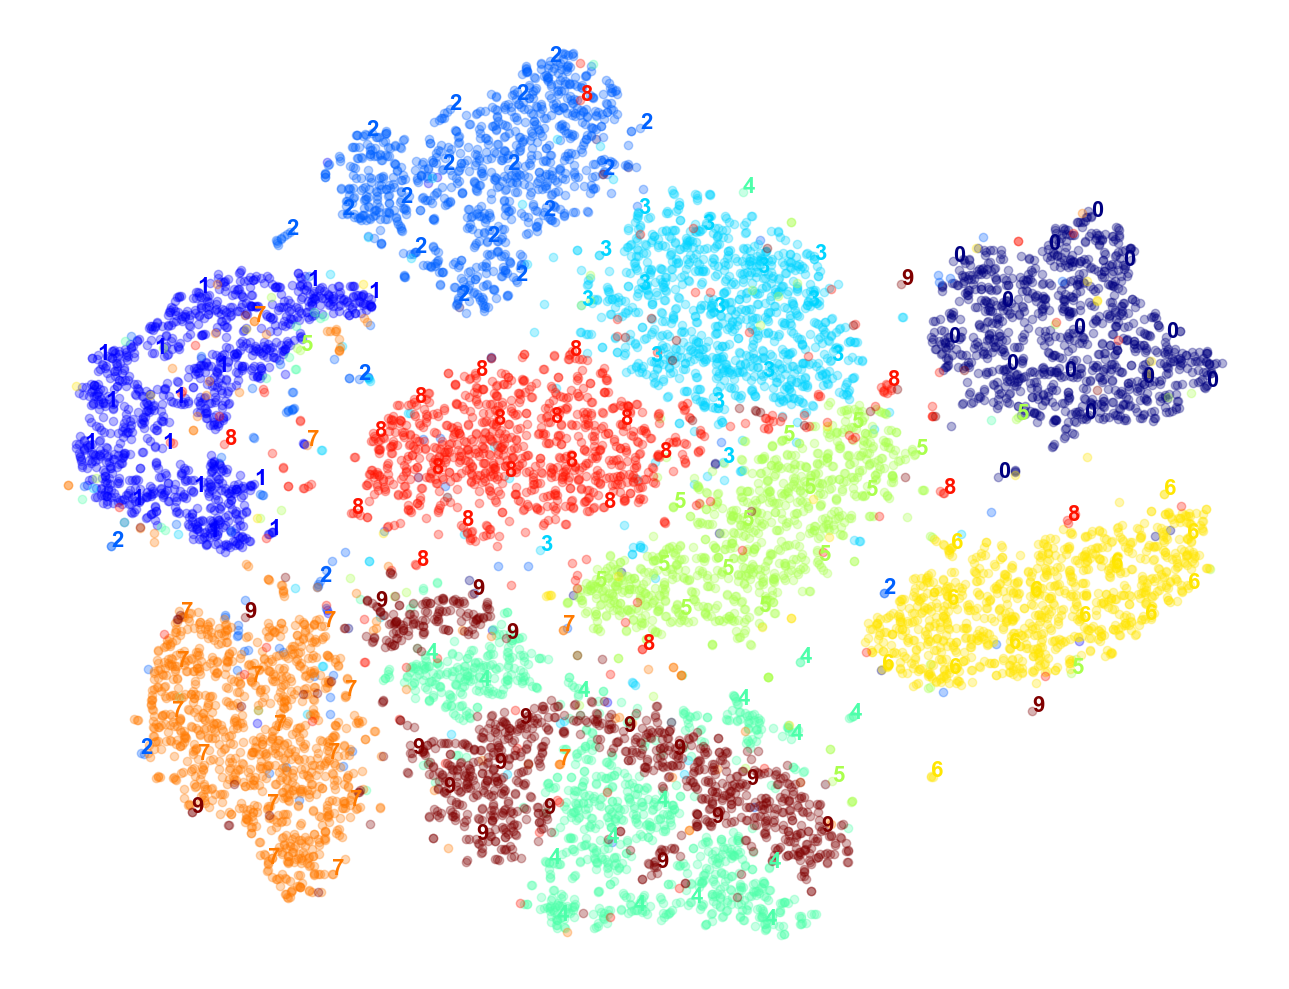

In [50]:
plot_digits(X_reduced, y) # Let's try it! First let's just write colored digits:

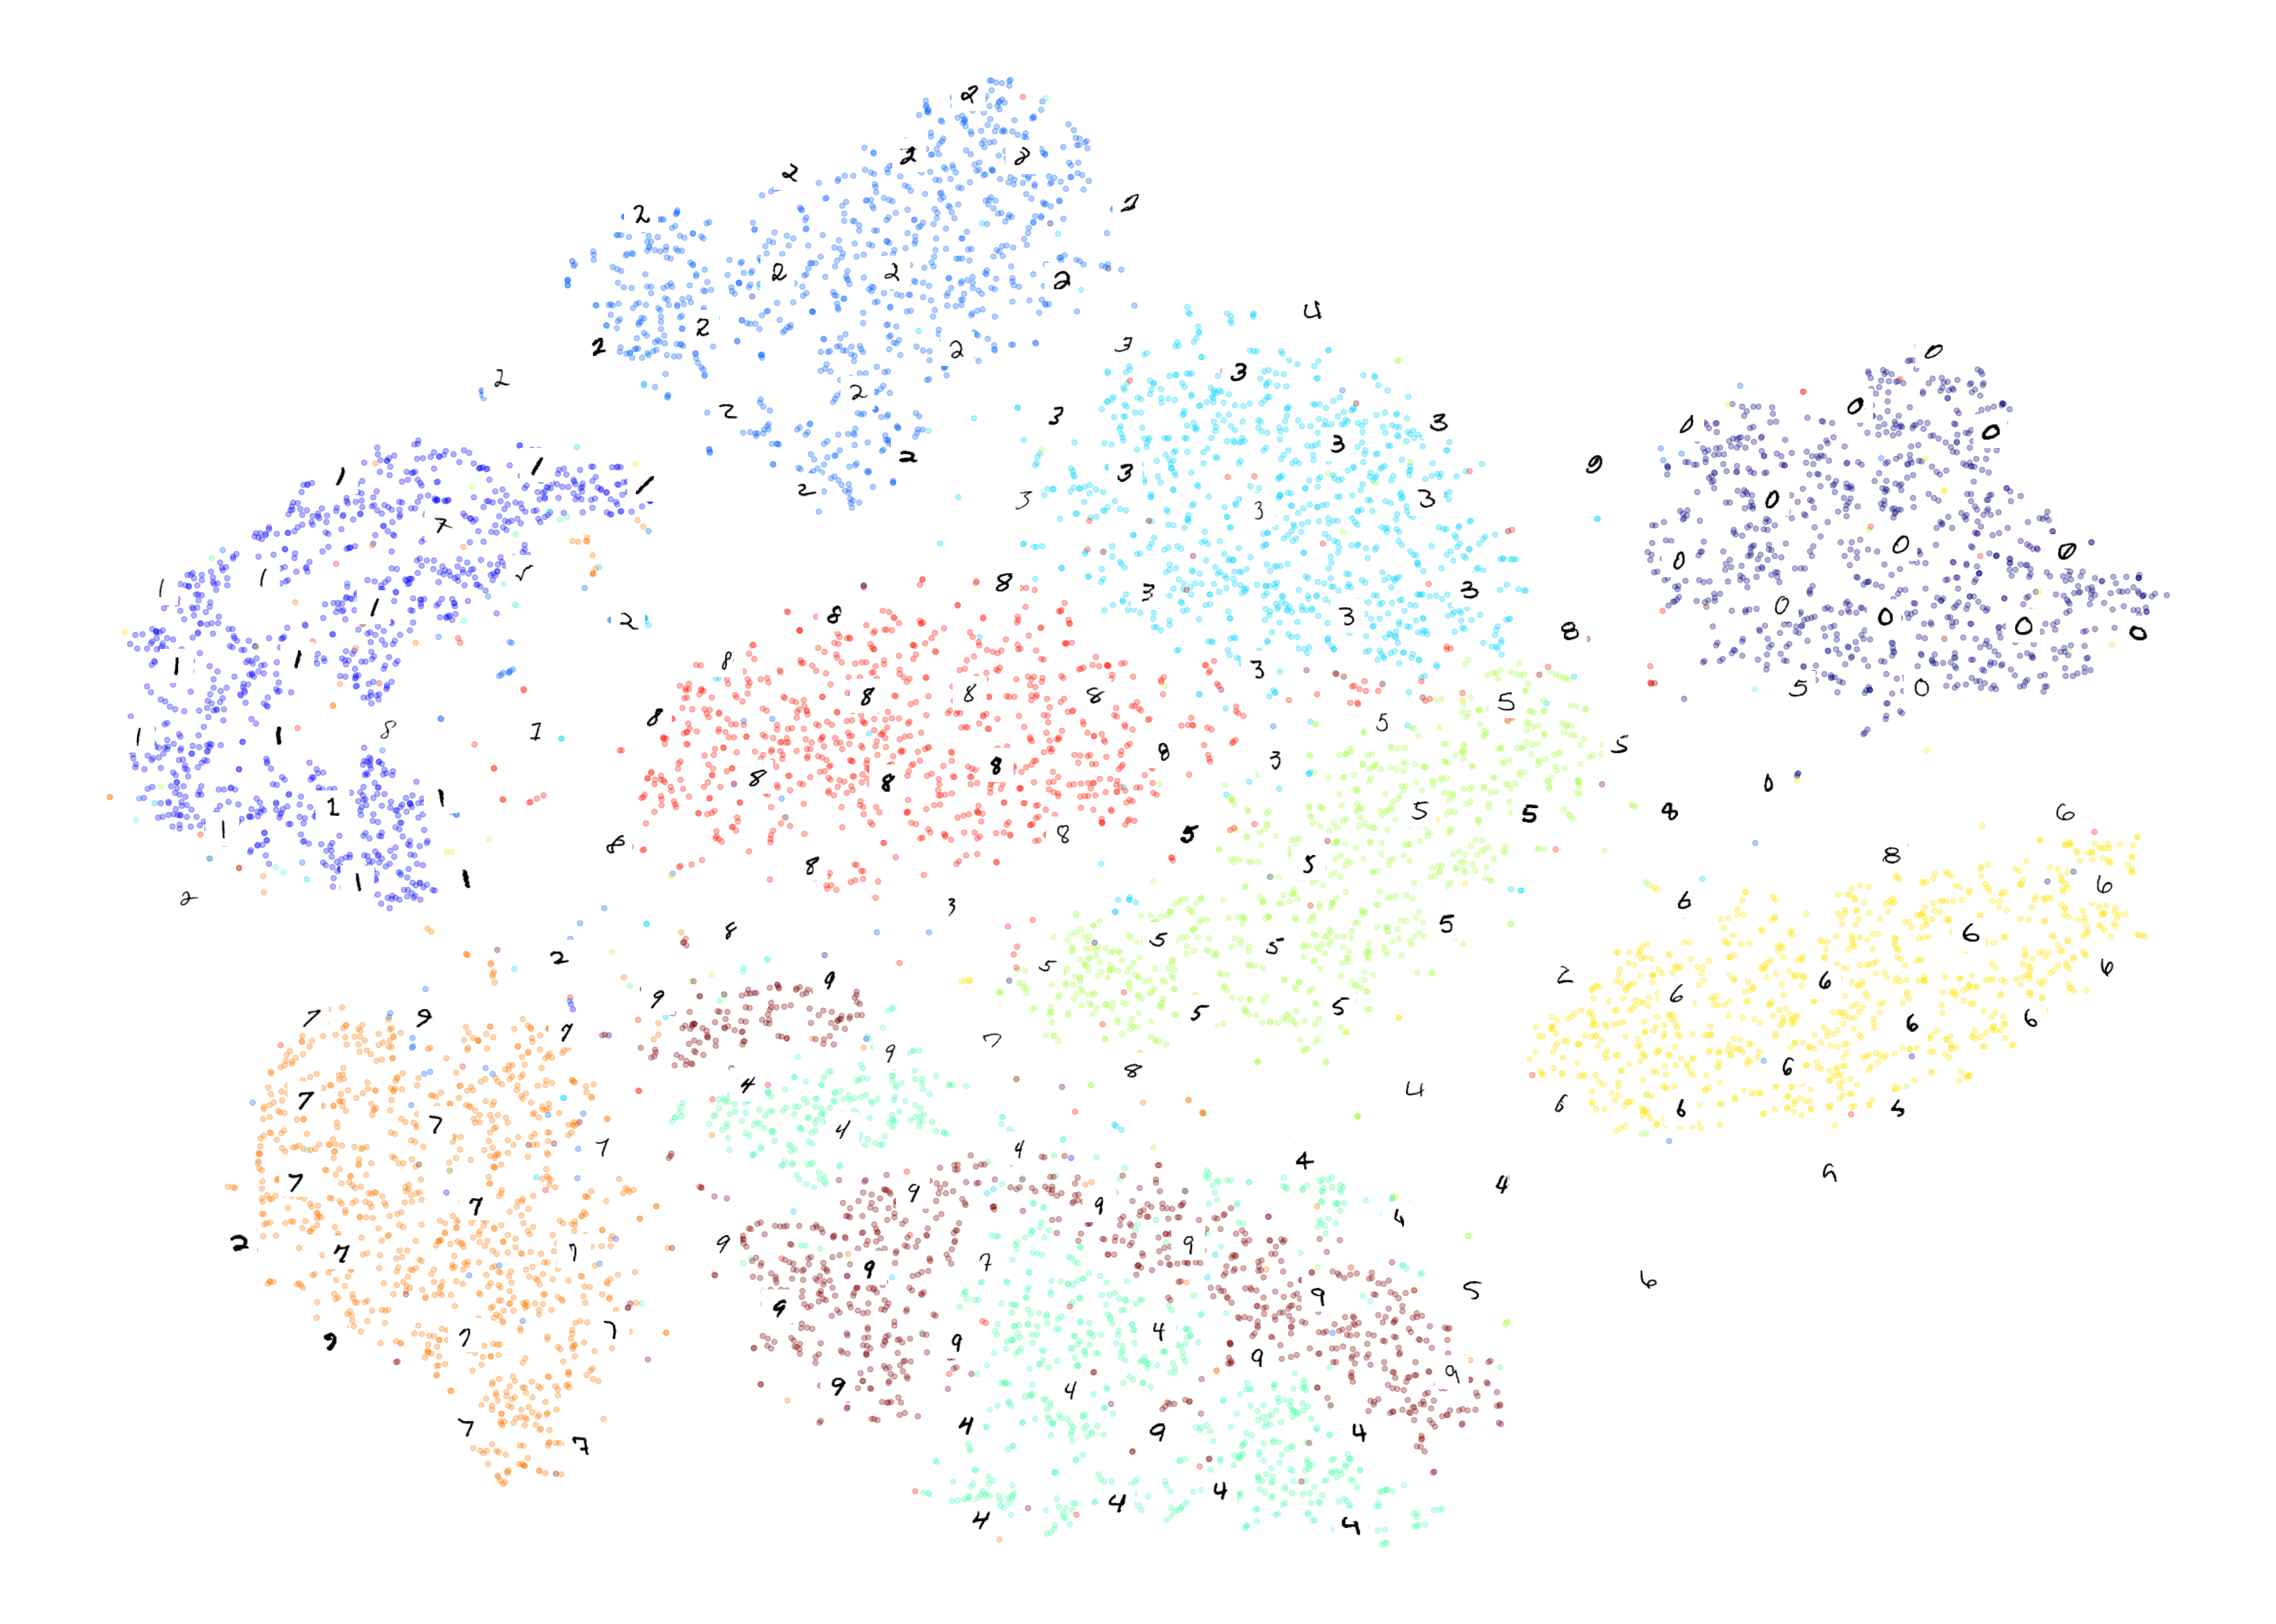

In [51]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

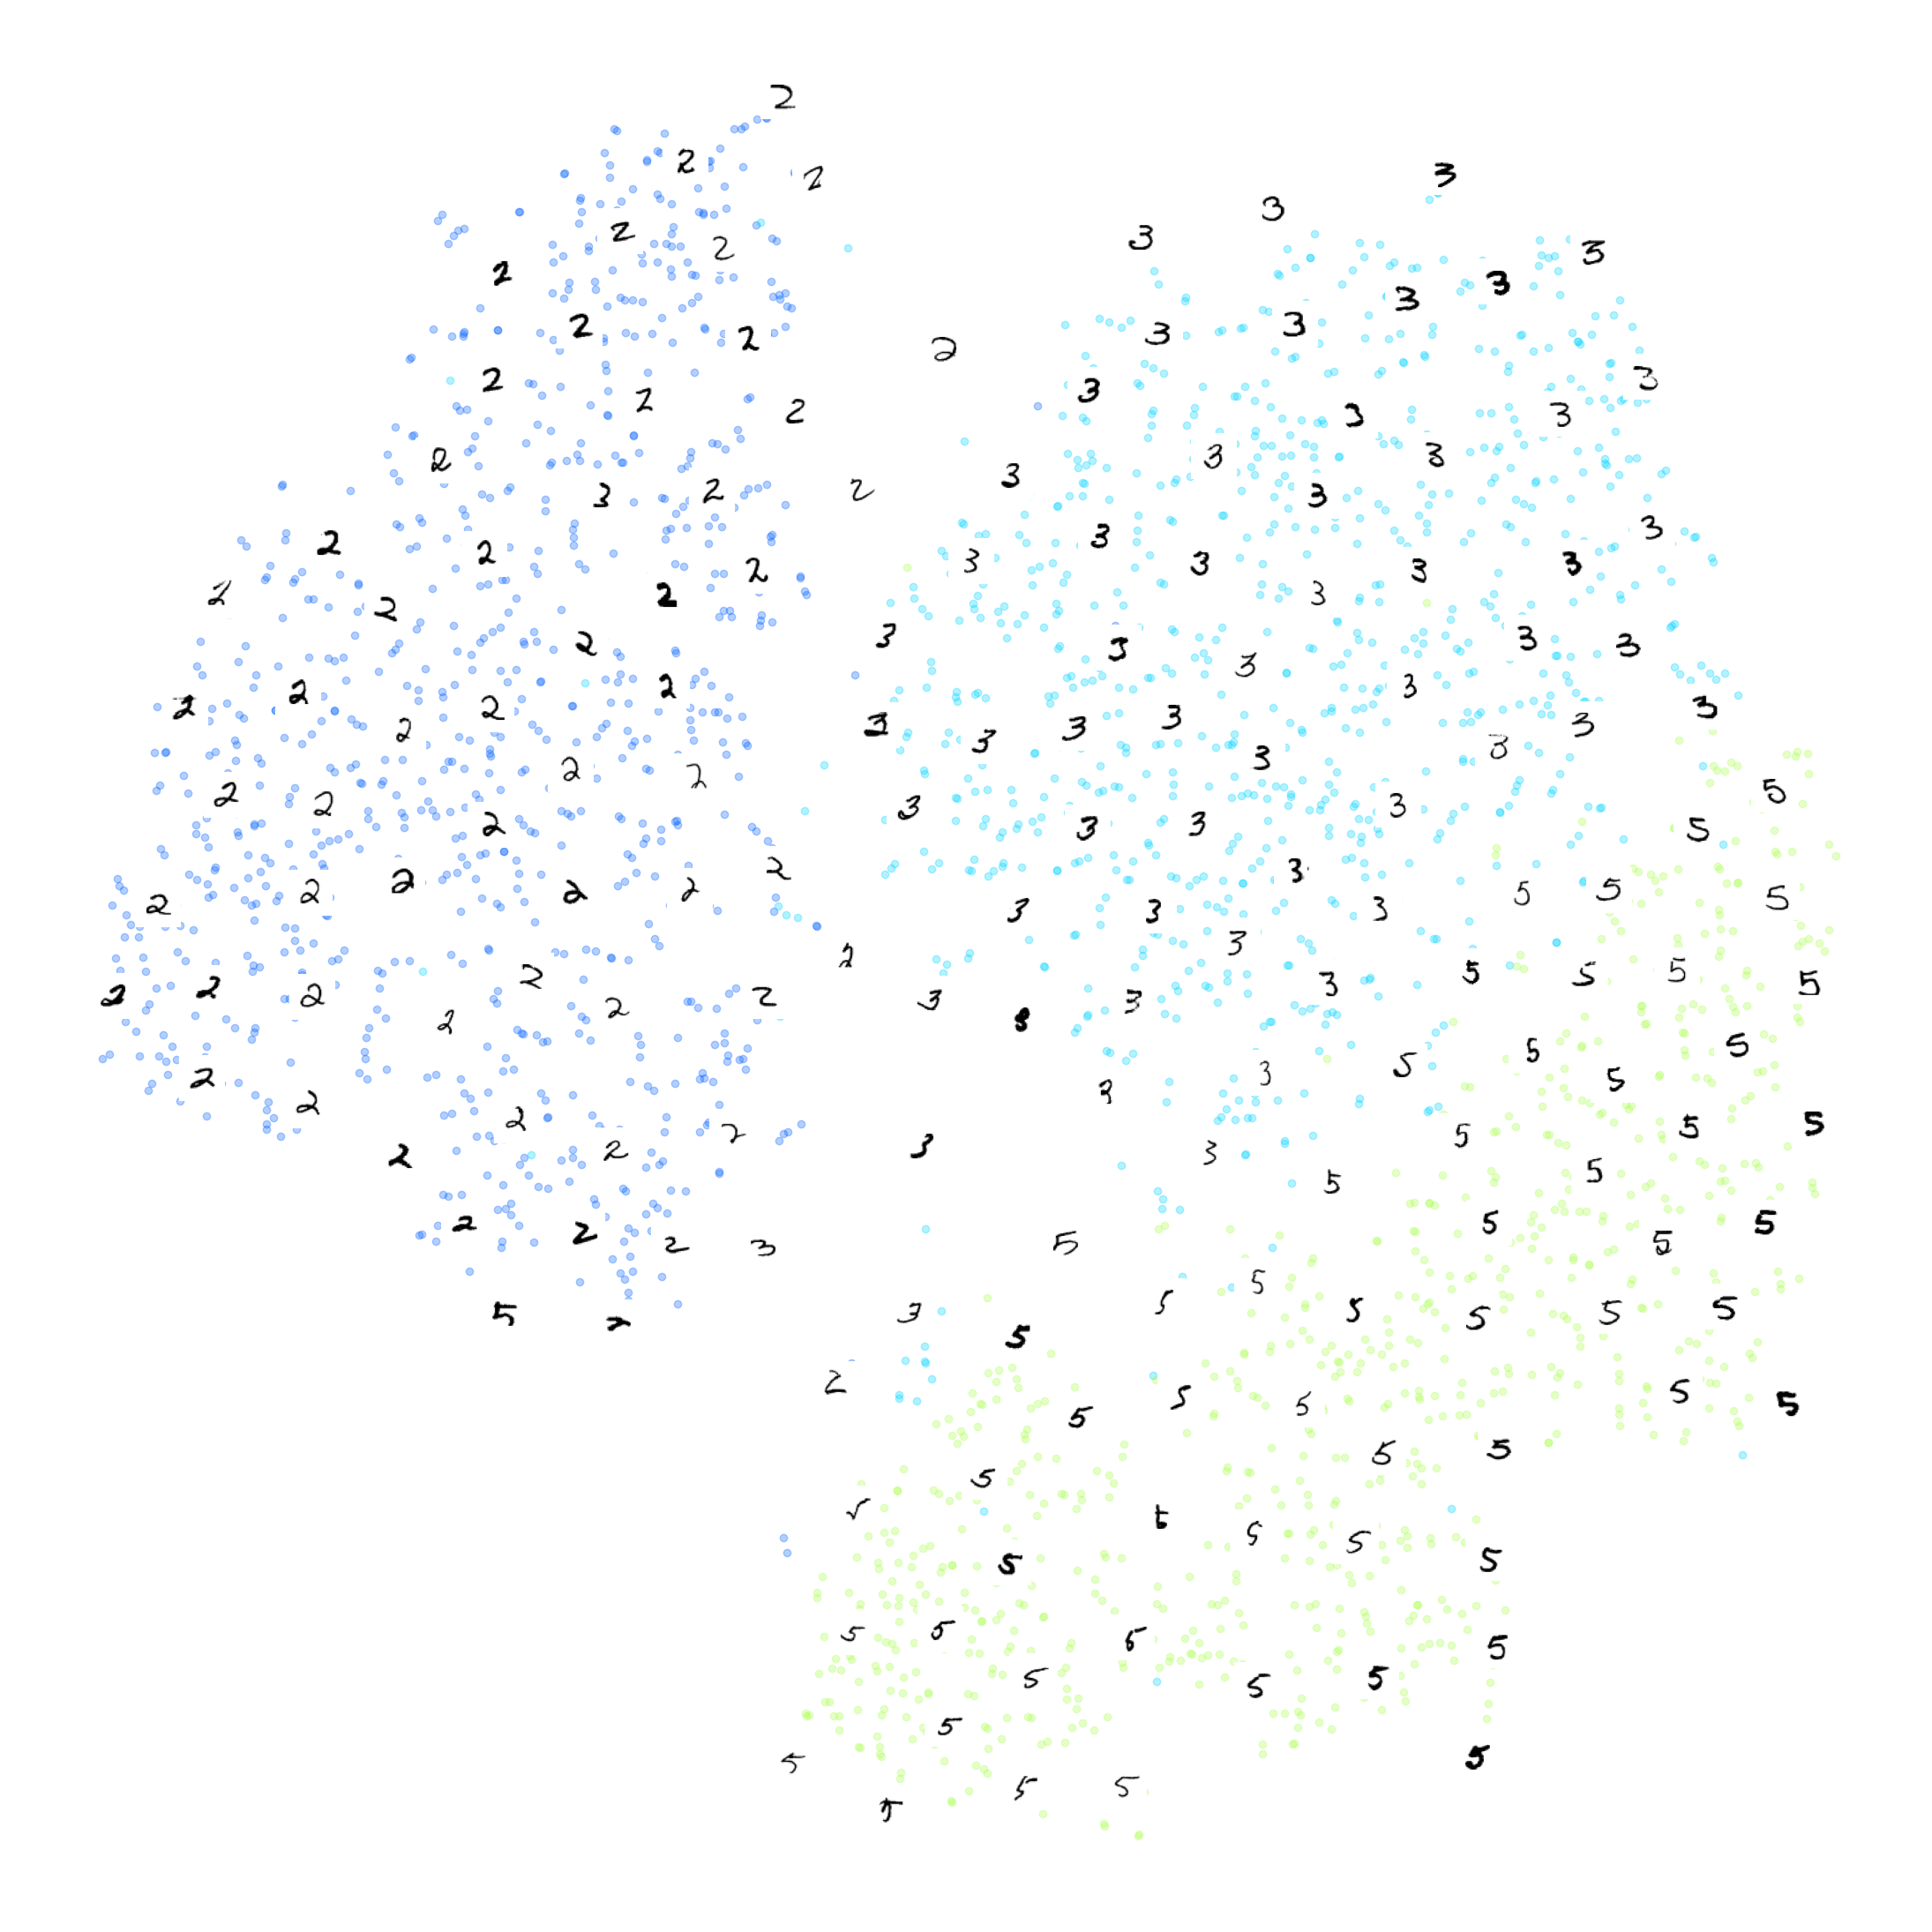

In [52]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

# Task 10: Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

PCA took 0.5s.


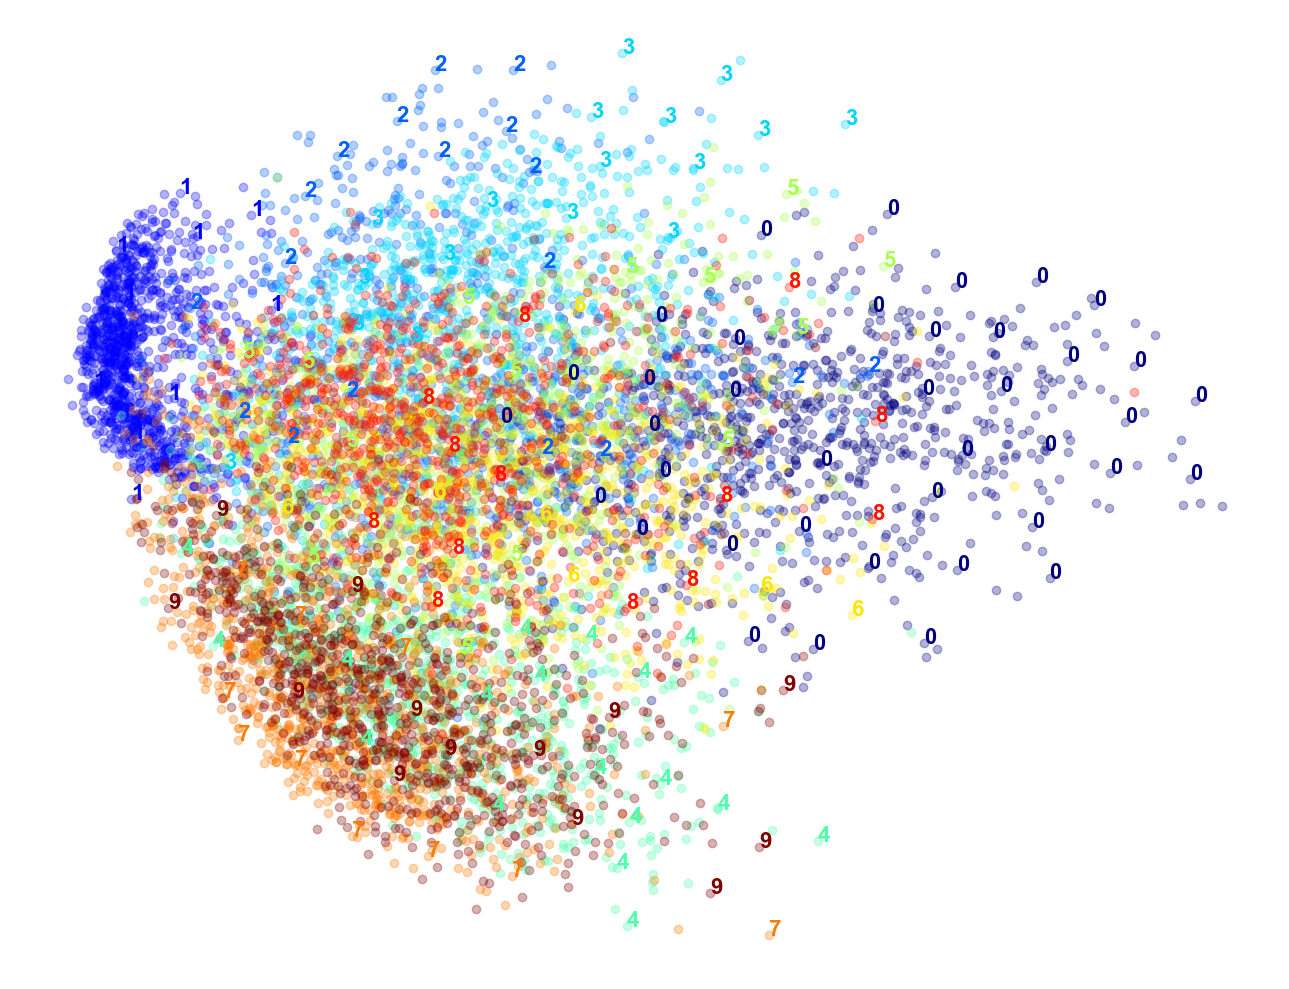

In [53]:
t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

LLE took 24.6s.


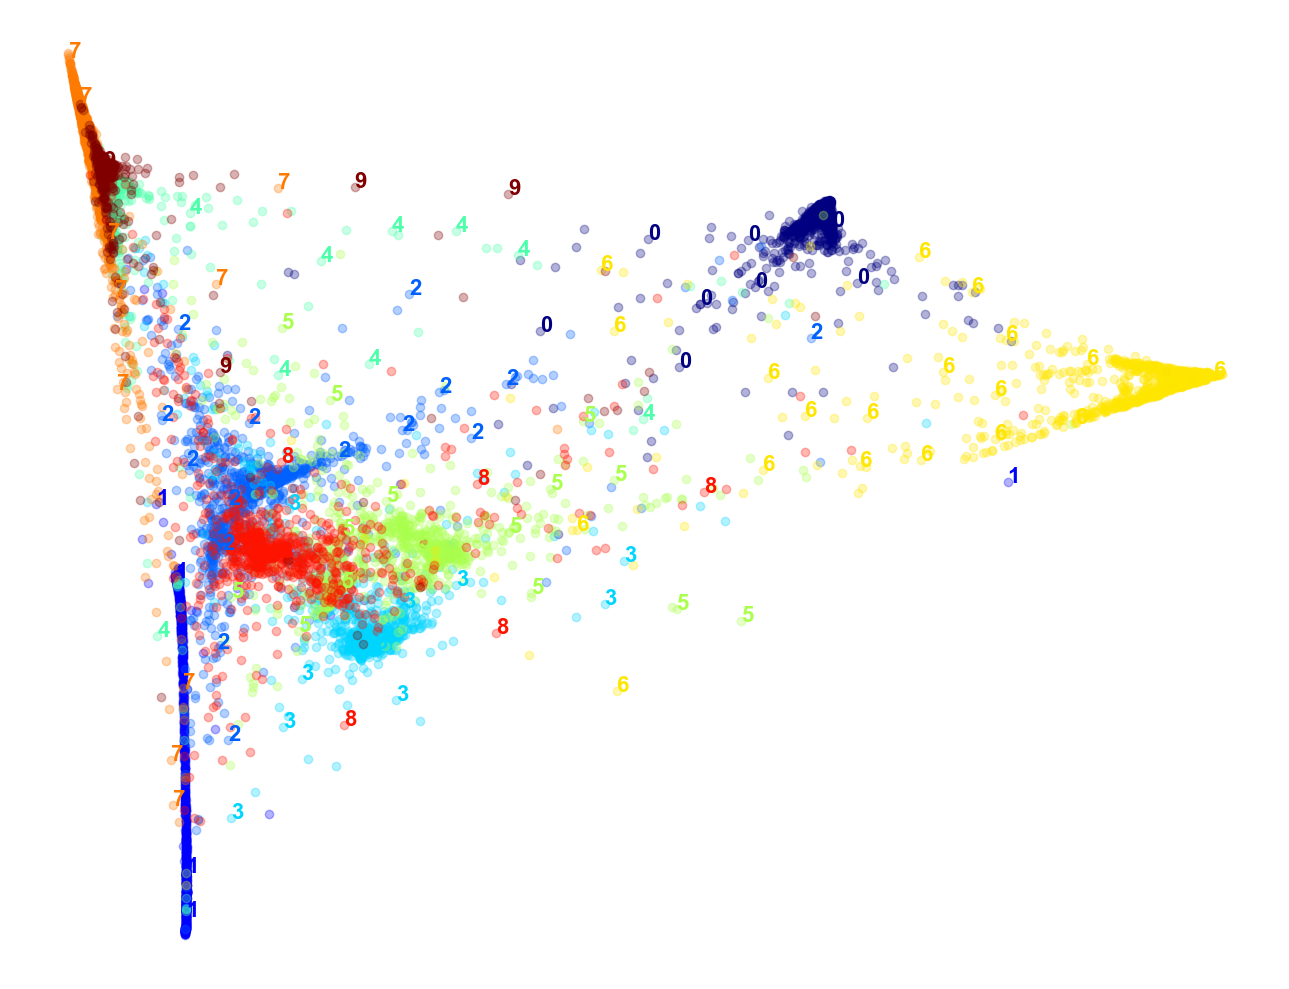

In [54]:
# Wow, PCA is blazingly fast! But although we do see a few clusters, there's way too much overlap. Let's try LLE:

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

PCA+LLE took 23.8s.


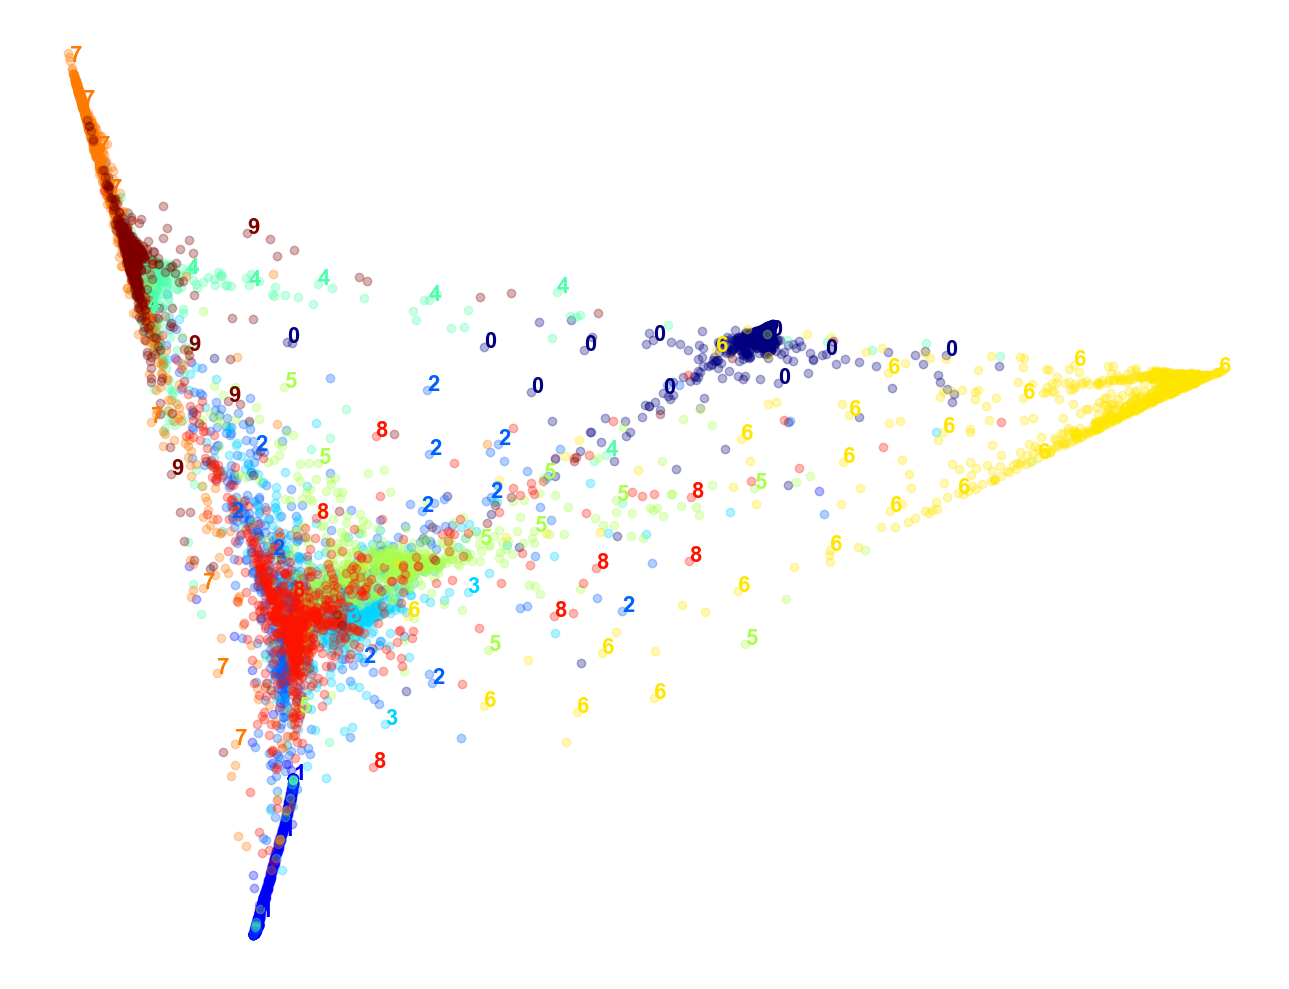

In [55]:
# That took a while, and the result does not look too good. Let's see what happens if we apply PCA first, preserving 95% of the variance:


pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


MDS took 252.3s (on just 2,000 MNIST images instead of 10,000).


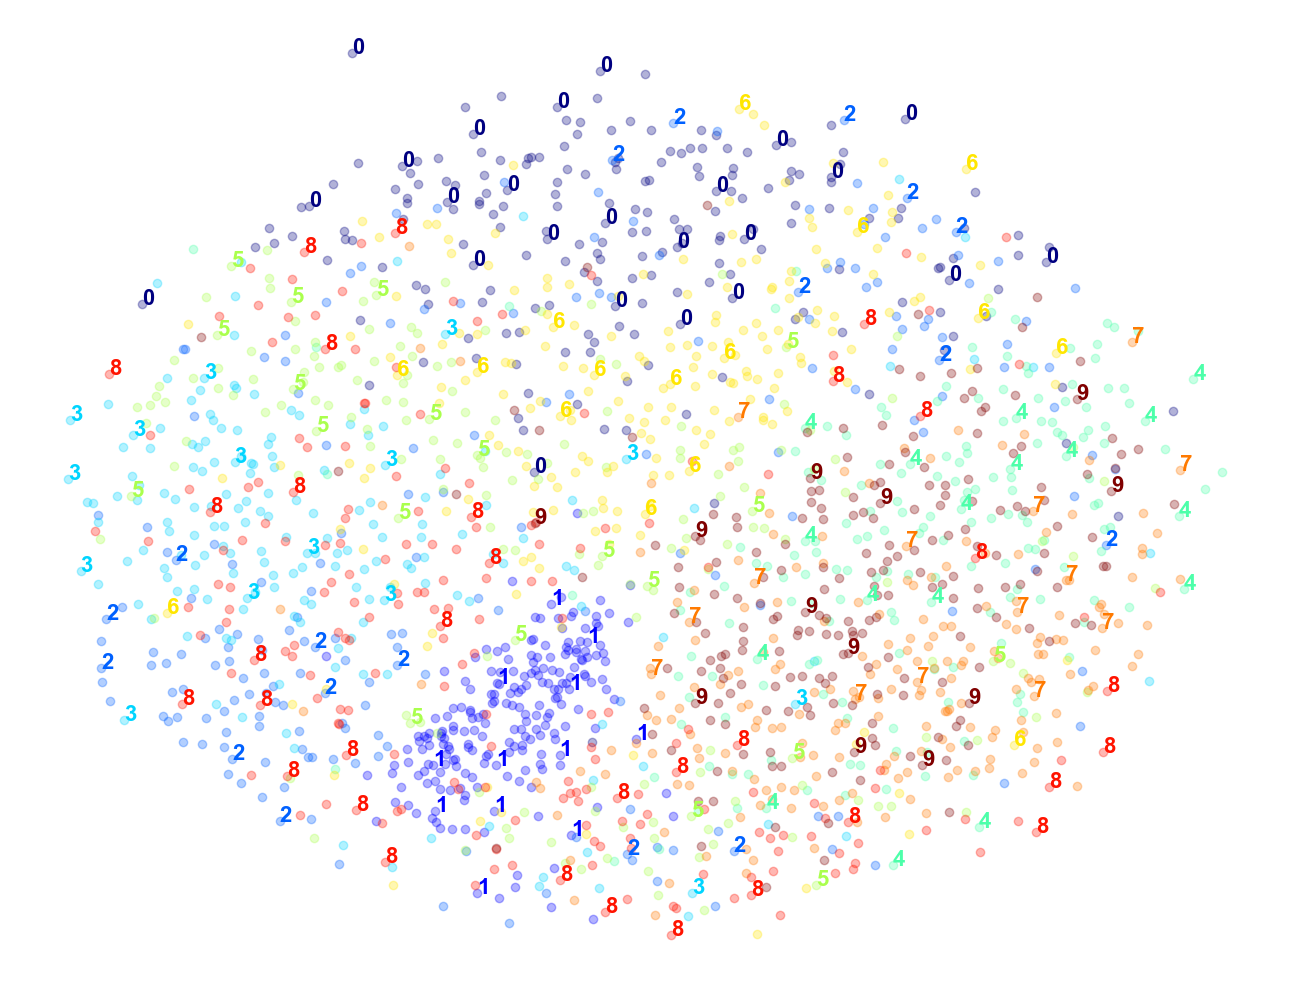

In [56]:
# The result is more or less the same, but this time it was almost 4× faster.

# Let's try MDS. It's much too long if we run it on 10,000 instances, so let's just try 2,000 for now:

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


PCA+MDS took 250.3s (on 2,000 MNIST images).


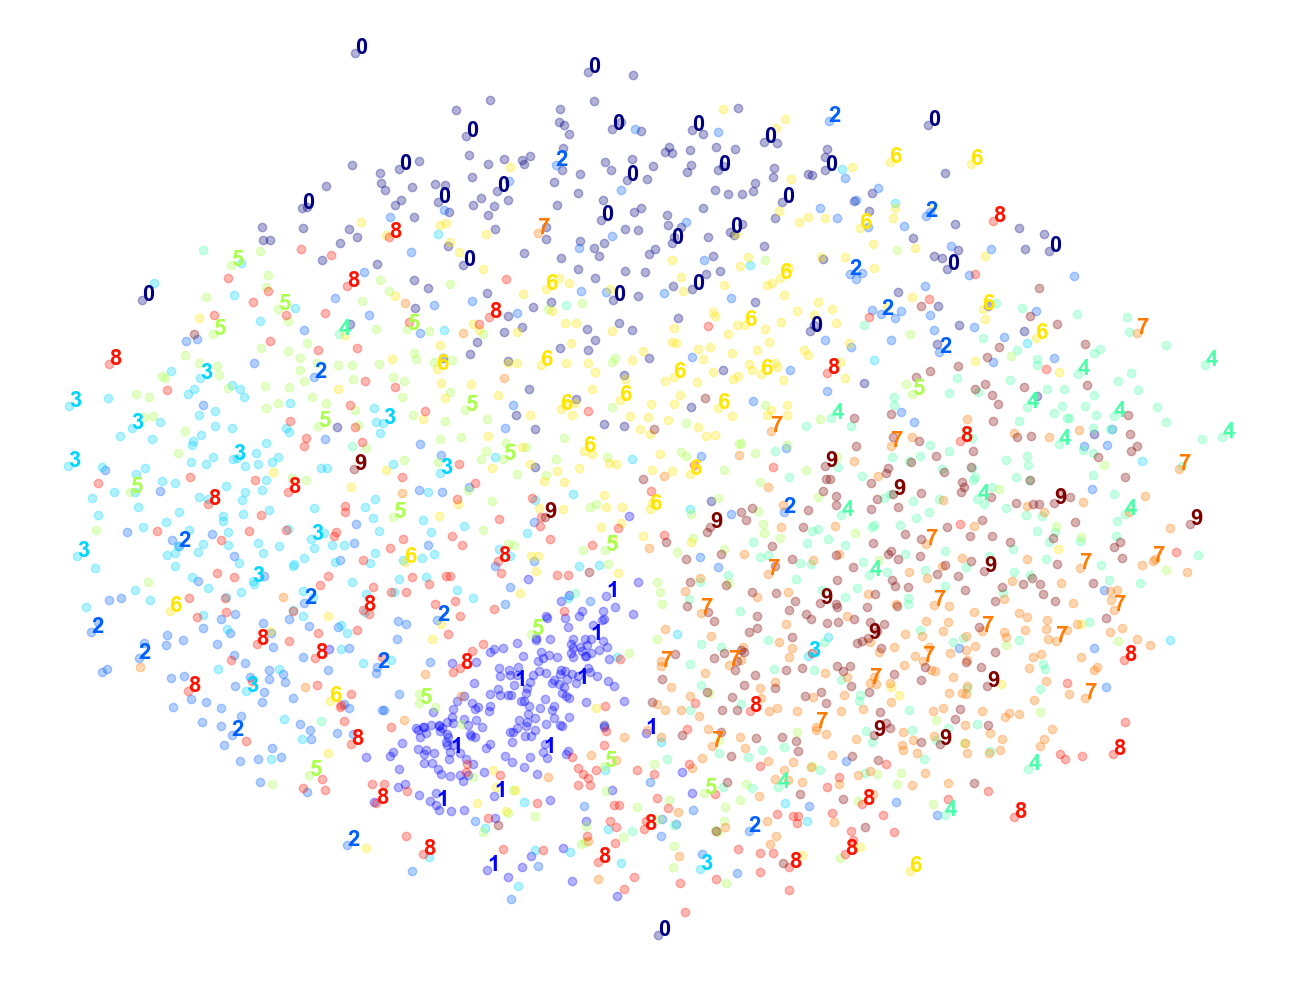

In [57]:
# Meh. This does not look great, all clusters overlap too much. Let's try with PCA first, perhaps it will be faster?

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS took {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

LDA took 2.5s.


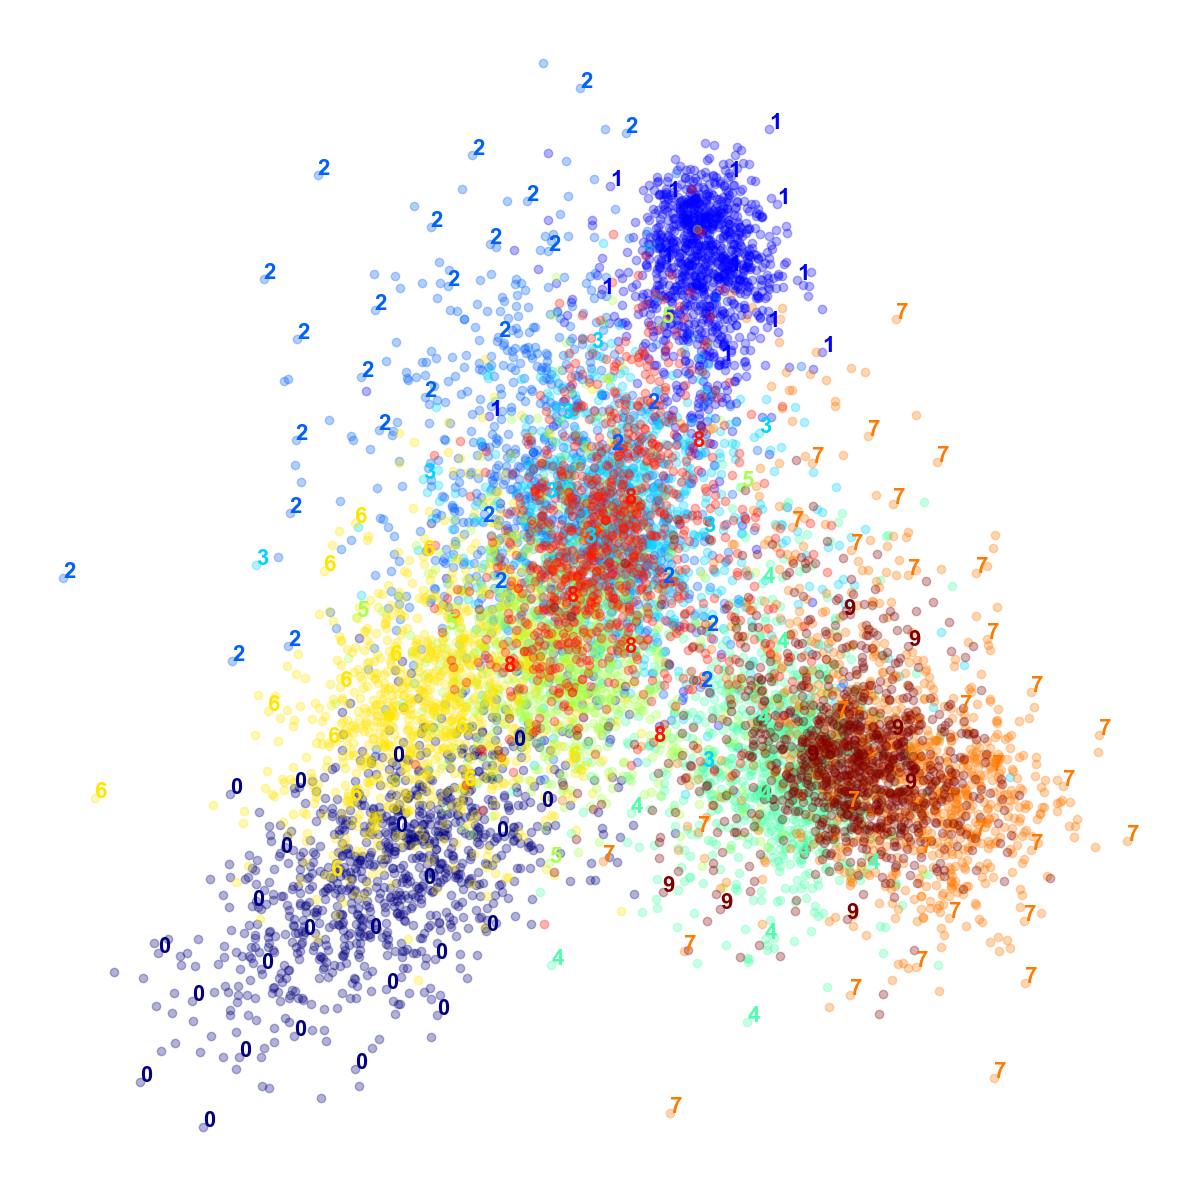

In [59]:
# Same result, and no speedup: PCA did not help (or hurt).

# Let's try LDA:

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA took {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

t-SNE took 69.3s.


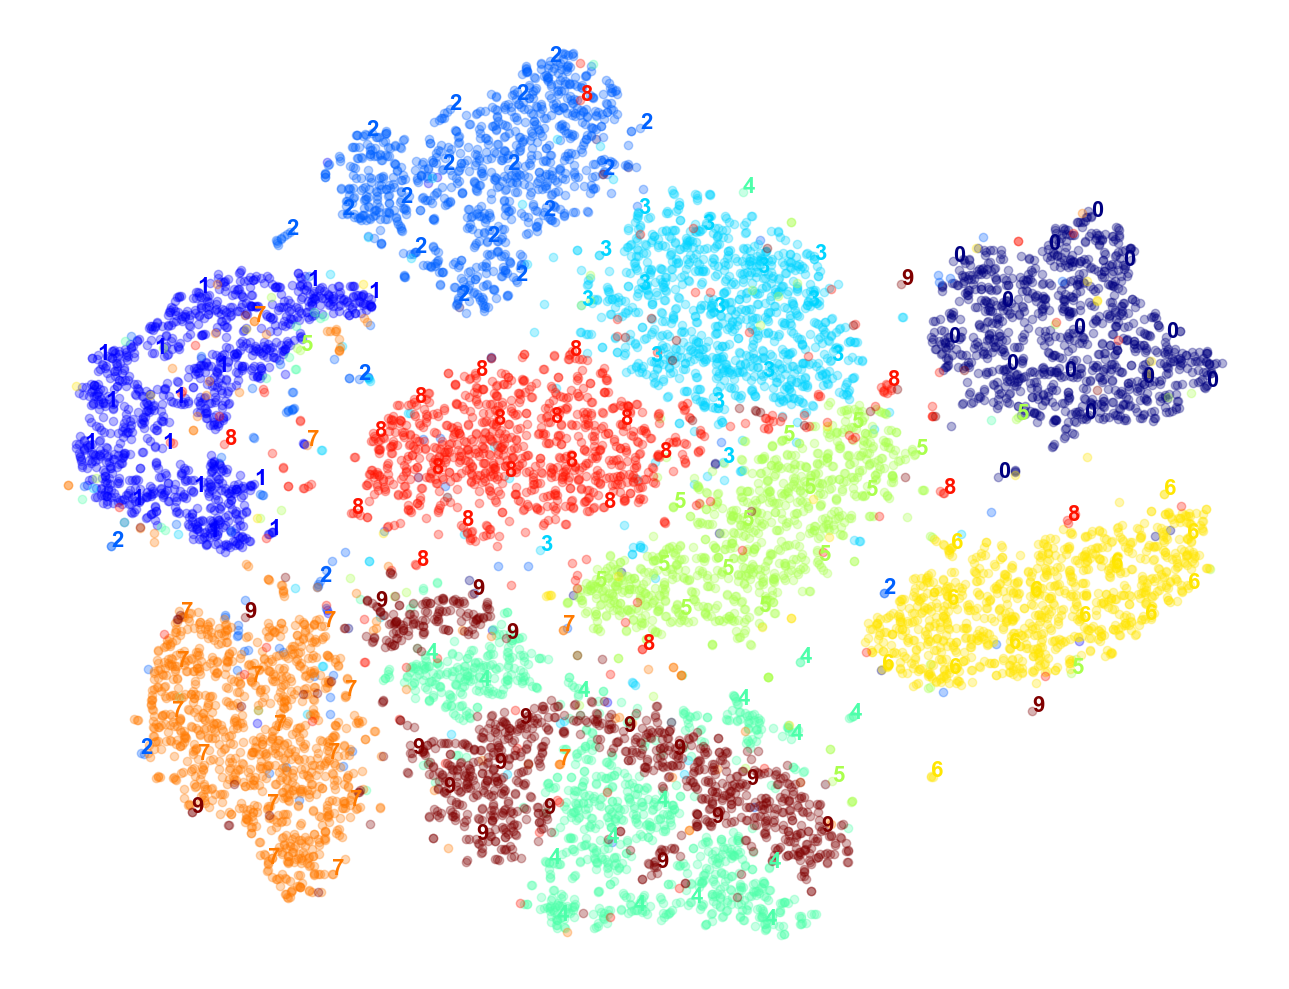

In [61]:
# This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.

# Well, it's pretty clear that t-SNE won this little competition, wouldn't you agree? We did not time it, so let's do that now:This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

PCA+t-SNE took 74.0s.


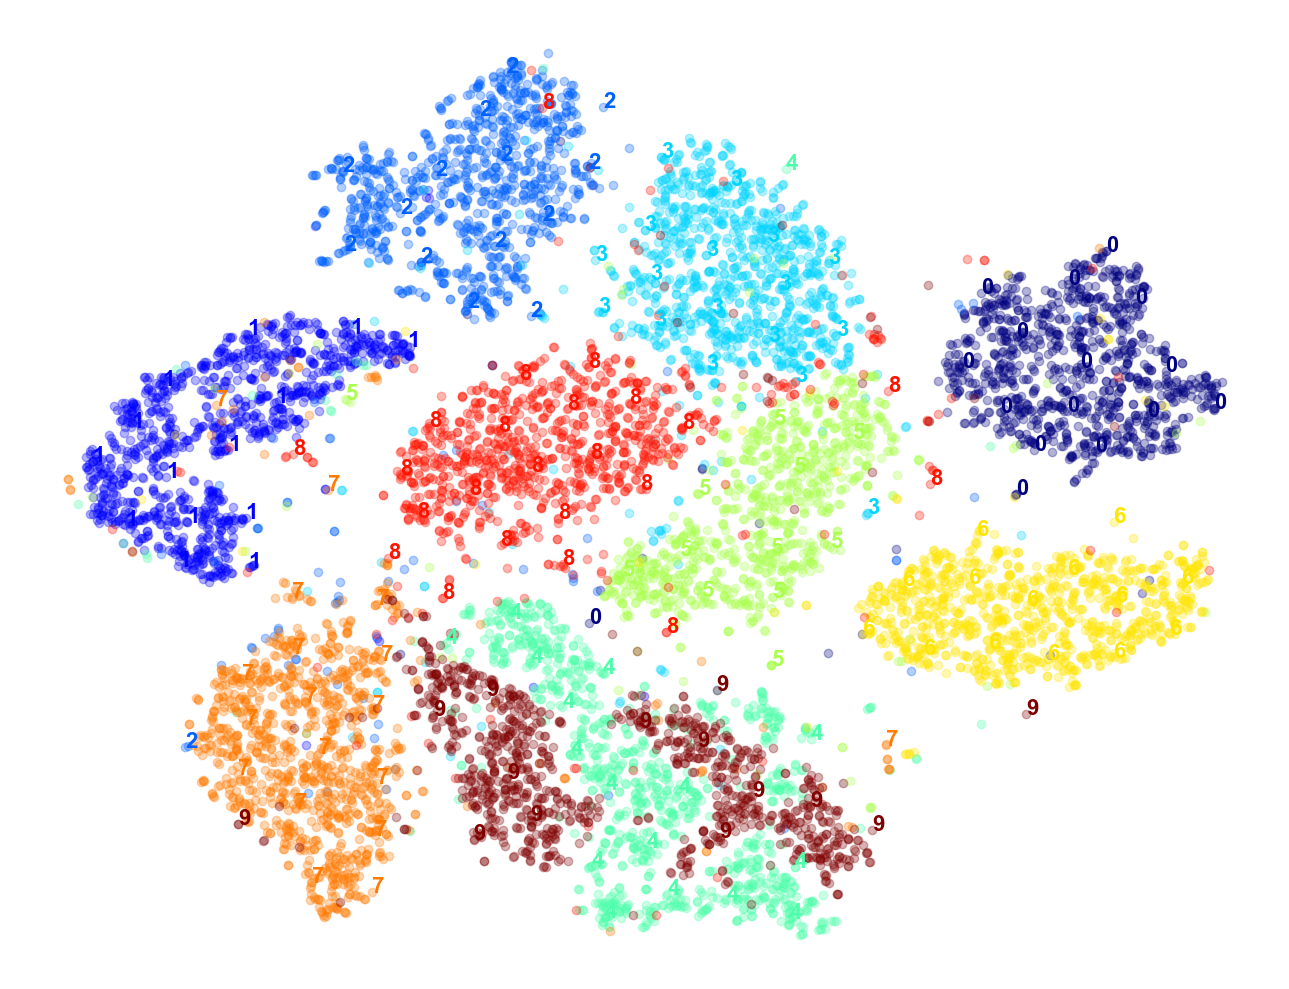

In [62]:
# It's twice slower than LLE, but still much faster than MDS, and the result looks great. Let's see if a bit of PCA can speed it up:

pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()


In [ ]:
# Yes, PCA roughly gave us over 2x speedup, without damaging the result. We have a winner!